In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from scipy import stats
from scipy.stats import beta

from conformal_utils import *
from fit_betas import beta_MoM, beta_variance

%load_ext autoreload
%autoreload 2

**Inputs:**
* softmax scores and labels
* $n_k$: Number of instances of each class to use when estimating $D$
* $n_k^{tune}$: Number of instances of each class to include in set used to tune the conformal parameter

**Output:**
Conformal prediction sets generated using the following methodology:
1. Fit a Beta distribution to the scores of the $n_k$ instances of class $k$ to get noisy $\alpha_k, \beta_k$ estimates
1. Let the prior $D$ be the KDE fit to the noisy $\alpha_k, \beta_k$ pairs
% 1. Let $\widehat{q}_k^{EB}$ be the ($1-\alpha$)%-quantile of $p(s_{k,new}|s_k,D)$
% 1. Apply conformal adjustment to $\widehat{q}_k^{EB}$
1. Find $\tilde{\alpha}$ such that, if we let $\widehat{q}_k$ be the ($1-\tilde{\alpha}$)%-quantile of $p(s_{k,new} | s_k, D)$, the prediction sets on the $1000 n_k^{tune}$ tuning points achieve a marginal coverage of $1-\alpha$ 
1. Generate prediction sets on unseen data using conformalized qhats

In [2]:
# Load data 
softmax_scores = torch.load('/home/eecs/tiffany_ding/code/SimCLRv2-Pytorch/.cache/logits/imagenet_train_subset_softmax.pt', map_location=torch.device('cpu'))
softmax_scores = softmax_scores.numpy()
labels = torch.load('/home/eecs/tiffany_ding/code/SimCLRv2-Pytorch/.cache/logits/imagenet_train_subset_labels.pt', map_location=torch.device('cpu'))
labels = labels.type(torch.LongTensor).numpy()

In [3]:
%%time

scores_all = 1 - softmax_scores

CPU times: user 755 ms, sys: 3.06 s, total: 3.81 s
Wall time: 3.83 s


In [4]:
alpha = .1
n_k = 20 
n_k_tune = 1
num_samples = 10000 # Number of Monte Carlo samples for estimating quantile of posterior score distribution
num_classes = 1000 # Number of classes in ImageNet

In [5]:
%%time

# Select subset of data to use for estimating D
scores1_all, labels1, scores_unused_all, labels_unused = split_X_and_y(scores_all, labels, n_k, num_classes=1000, seed=0)

# Select subset of data to use for computing conformal adjustment
scores2_all, labels2, scores_val_all, labels_val = split_X_and_y(scores_unused_all, labels_unused, n_k_tune, num_classes=1000, seed=0)


CPU times: user 6.51 s, sys: 2min 27s, total: 2min 33s
Wall time: 2min 37s


In [6]:
%%time

# Only select data for which k is true class
scores1 = np.array([scores1_all[row,labels1[row]] for row in range(len(labels1))])

CPU times: user 11.9 ms, sys: 28.4 ms, total: 40.3 ms
Wall time: 39.1 ms


## 1. Estimate noisy $\alpha_k, \beta_k$

In [7]:
est_alphas = np.zeros((num_classes,))
est_betas = np.zeros((num_classes,))

for k in range(num_classes):
    class_k_scores = scores1[labels1==k]
    
    est_alpha, est_beta = beta_MoM(class_k_scores)
    
    print(f"[Class {k}] Est. params: {est_alpha:.2f}, {est_beta:.2f} || Associated variance: {beta_variance(est_alpha, est_beta):.3f}")
#     print(beta.fit(class_k_scores, method='MLE')[:2])
    
    est_alphas[k] = est_alpha
    est_betas[k] = est_beta

[Class 0] Est. params: 0.06, 0.79 || Associated variance: 0.038
[Class 1] Est. params: 0.14, 0.78 || Associated variance: 0.066
[Class 2] Est. params: 0.48, 0.94 || Associated variance: 0.093
[Class 3] Est. params: 0.11, 0.35 || Associated variance: 0.124
[Class 4] Est. params: 0.13, 0.43 || Associated variance: 0.116
[Class 5] Est. params: 0.35, 0.59 || Associated variance: 0.120
[Class 6] Est. params: 0.38, 0.78 || Associated variance: 0.102
[Class 7] Est. params: 0.23, 0.49 || Associated variance: 0.127
[Class 8] Est. params: 0.17, 0.42 || Associated variance: 0.128
[Class 9] Est. params: 0.08, 2.29 || Associated variance: 0.010
[Class 10] Est. params: 0.05, 0.53 || Associated variance: 0.053
[Class 11] Est. params: 0.12, 0.86 || Associated variance: 0.053
[Class 12] Est. params: 0.06, 0.25 || Associated variance: 0.117
[Class 13] Est. params: 0.11, 0.55 || Associated variance: 0.081
[Class 14] Est. params: 0.01, 0.21 || Associated variance: 0.045
[Class 15] Est. params: 0.14, 1.25 

[Class 398] Est. params: 0.02, 0.08 || Associated variance: 0.141
[Class 399] Est. params: 0.24, 1.36 || Associated variance: 0.049
[Class 400] Est. params: 0.28, 0.37 || Associated variance: 0.148
[Class 401] Est. params: 0.16, 0.25 || Associated variance: 0.170
[Class 402] Est. params: 0.12, 0.49 || Associated variance: 0.098
[Class 403] Est. params: 0.05, 0.32 || Associated variance: 0.080
[Class 404] Est. params: 0.55, 1.63 || Associated variance: 0.059
[Class 405] Est. params: 0.04, 0.15 || Associated variance: 0.141
[Class 406] Est. params: 0.09, 0.35 || Associated variance: 0.113
[Class 407] Est. params: 0.45, 0.58 || Associated variance: 0.121
[Class 408] Est. params: 0.06, 0.21 || Associated variance: 0.135
[Class 409] Est. params: 0.17, 0.22 || Associated variance: 0.178
[Class 410] Est. params: 0.04, 0.25 || Associated variance: 0.085
[Class 411] Est. params: 0.18, 0.40 || Associated variance: 0.134
[Class 412] Est. params: 0.32, 0.23 || Associated variance: 0.157
[Class 413

[Class 550] Est. params: 0.18, 0.29 || Associated variance: 0.159
[Class 551] Est. params: 0.08, 0.29 || Associated variance: 0.123
[Class 552] Est. params: 0.11, 0.55 || Associated variance: 0.083
[Class 553] Est. params: 0.33, 0.56 || Associated variance: 0.124
[Class 554] Est. params: 0.18, 0.44 || Associated variance: 0.127
[Class 555] Est. params: 0.05, 0.12 || Associated variance: 0.172
[Class 556] Est. params: 0.12, 0.64 || Associated variance: 0.074
[Class 557] Est. params: 0.16, 0.51 || Associated variance: 0.108
[Class 558] Est. params: 0.28, 1.39 || Associated variance: 0.052
[Class 559] Est. params: 0.08, 0.17 || Associated variance: 0.174
[Class 560] Est. params: 0.08, 0.40 || Associated variance: 0.093
[Class 561] Est. params: 0.05, 0.20 || Associated variance: 0.125
[Class 562] Est. params: 0.16, 0.82 || Associated variance: 0.069
[Class 563] Est. params: 0.37, 1.09 || Associated variance: 0.077
[Class 564] Est. params: 0.06, 0.46 || Associated variance: 0.064
[Class 565

[Class 952] Est. params: 0.22, 1.29 || Associated variance: 0.050
[Class 953] Est. params: 0.02, 0.08 || Associated variance: 0.157
[Class 954] Est. params: 0.22, 0.94 || Associated variance: 0.072
[Class 955] Est. params: 0.25, 9.57 || Associated variance: 0.002
[Class 956] Est. params: 0.05, 0.55 || Associated variance: 0.050
[Class 957] Est. params: 0.02, 0.34 || Associated variance: 0.033
[Class 958] Est. params: 0.10, 0.68 || Associated variance: 0.065
[Class 959] Est. params: 0.12, 0.50 || Associated variance: 0.096
[Class 960] Est. params: 0.09, 0.24 || Associated variance: 0.150
[Class 961] Est. params: 0.29, 0.89 || Associated variance: 0.085
[Class 962] Est. params: 0.19, 0.44 || Associated variance: 0.130
[Class 963] Est. params: 0.09, 0.38 || Associated variance: 0.103
[Class 964] Est. params: 0.14, 0.33 || Associated variance: 0.144
[Class 965] Est. params: 0.30, 1.14 || Associated variance: 0.067
[Class 966] Est. params: 0.41, 0.15 || Associated variance: 0.125
[Class 967

#### Debugging

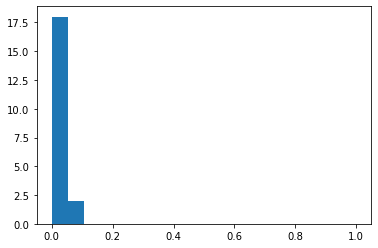

In [8]:
k = 97 # 51
bins = np.linspace(0, 1, 20)
plt.hist(scores1[labels1==k], bins=bins, density=False)

# xs = np.linspace(0,1,100)
# plt.plot(xs,beta.pdf(xs, a=est_alphas[k], b=est_betas[k]))

plt.show()

There are some classes that the model always predicts correctly within our small n=20 sample, so all of the conformal scores are concentrated near 0. This makes it so the Beta distribution that is fit is weird. 

## 2. Define prior $D$
Fit KDE to noisy $\alpha_k, \beta_k$.

Comment: It seems like KDE is very sensitive to outliers

Some of the $\alpha_k, \beta_k$ estimates are quite extreme. This generally happens when the sampled scores are all close to 0. 

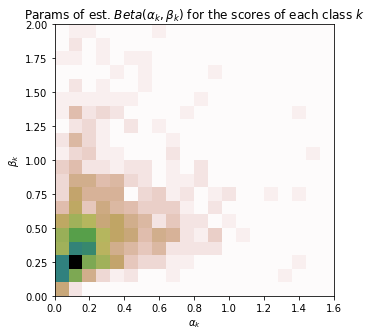

In [9]:
# (Optional) Visualize
xmin, xmax = 0, 1.6
ymin, ymax = 0, 2
bins = 20
plt.figure(figsize=(5,5))
cts, xedges, yedges, img = plt.hist2d(est_alphas, est_betas, 
                                      bins=bins, range=[[xmin, xmax], [ymin, ymax]], 
                                      cmap=plt.cm.gist_earth_r)
plt.xlabel('$\\alpha_k$')
plt.ylabel('$\\beta_k$')
plt.title('Params of est. $Beta(\\alpha_k, \\beta_k)$ for the scores of each class $k$')
plt.show()

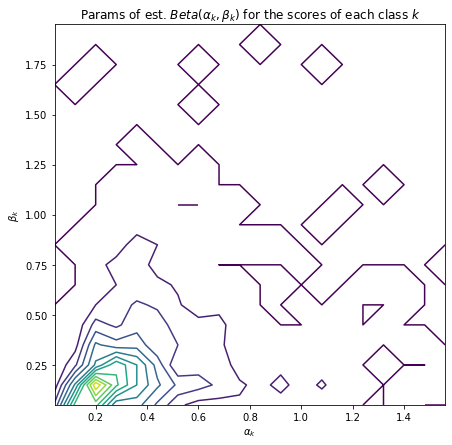

In [10]:
# (Optional) Contour plot visualization 
X, Y = np.meshgrid((xedges[:-1] + xedges[1:]) / 2, (yedges[:-1] + yedges[1:]) / 2)

plt.figure(figsize=(7,7))
plt.contour(X, Y, cts, levels=12)
plt.xlabel('$\\alpha_k$')
plt.ylabel('$\\beta_k$')
plt.title('Params of est. $Beta(\\alpha_k, \\beta_k)$ for the scores of each class $k$')
plt.show()

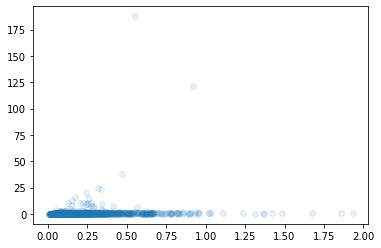

In [11]:
plt.scatter(est_alphas, est_betas, alpha=0.1)
# plt.xlim(xmin, xmax)
# plt.ylim(ymin, ymax)
# plt.show()

There are definitely some outliers!

#### Option 1: Apply KDE to all data

In [12]:
# Apply KDE to smooth
values = np.vstack([est_alphas, est_betas])
kernel = stats.gaussian_kde(values)

In [13]:
# Visualize
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel(positions).T, X.shape)

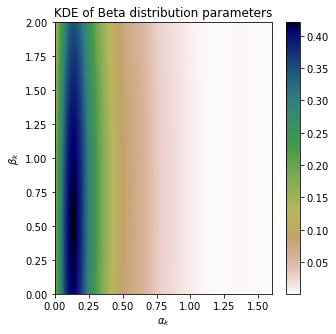

In [14]:
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r, extent=[xmin, xmax, ymin, ymax])
ax.set_xlabel('$\\alpha_k$')
ax.set_ylabel('$\\beta_k$')
ax.set_title('KDE of Beta distribution parameters')
fig.colorbar(im)
plt.show()

This doesn't look at all like contour plot from above! I think it's because of outliers.

#### Option 2: Exclude outliers before applying KDE

Question: What criteria should we use for determining what is an outlier?
* Option 1: Let threshold be mean + 2 std devs
* Option 2: Let threshold be 99% quantile (I think I will go with this for now)

In [15]:
mean_est_betas = np.mean(est_betas)
sd_est_betas = np.std(est_betas)
print(f'Mean of estimated betas: {mean_est_betas:.3f}')
print(f'Std dev of estimated betas: {sd_est_betas:.3f}')

Mean of estimated betas: 1.151
Std dev of estimated betas: 7.356


In [16]:
est_betas_quantile = np.quantile(est_betas, .99)
print(f'99% quantile of estimated betas: {est_betas_quantile:.3f}')

99% quantile of estimated betas: 10.454


In [17]:
# Exclude distributions with extreme estimated Betas
beta_thresh = est_betas_quantile
extreme_beta_idx = (est_betas > beta_thresh)
values = np.vstack([est_alphas[~extreme_beta_idx], est_betas[~extreme_beta_idx]])
kernel2 = stats.gaussian_kde(values)

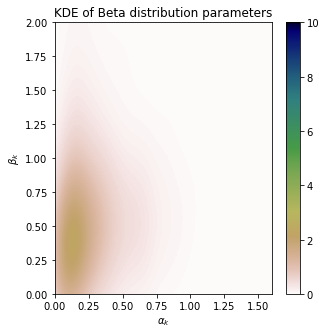

In [20]:
# Visualize
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel2(positions).T, X.shape)

fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(np.rot90(Z), 
               vmin=0, vmax=10, 
               cmap=plt.cm.gist_earth_r, extent=[xmin, xmax, ymin, ymax])
ax.set_xlabel('$\\alpha_k$')
ax.set_ylabel('$\\beta_k$')
ax.set_title('KDE of Beta distribution parameters')
fig.colorbar(im)
plt.show()

Our KDE estimate looks much better after excluding outliers, so we let $D$ be this KDE

In [153]:
D = kernel2

## 3. Compute $\widehat{q}_k^{EB}$ for each class $k$

The code in this section is based on `get_posterior_quantiles_oracle.py`, but many modifications have been made

In [173]:
def compute_classk_prod_f(a, b, classk_scores):
    '''
    Computes $\prod_{i=1}^{n_k} f(s_{k,i}; \alpha_k, \beta_k)$
    
    Inputs:
        a, b: parameters of Beta(a,b)
        class_k_scores: vector of scores for class k
    '''
    
    # Weirdly, some scores are exactly 0, which is a problem because the Beta 
    # density blows up at 0 for some alpha, beta values. We replace these 0 
    # values with randomly sampled values from classk_scores
    classk_scores[classk_scores == 0] = np.random.choice(classk_scores[~(classk_scores == 0)], 
                                                         size=classk_scores[classk_scores == 0].shape,
                                                         replace=True)
    
    f_ski = beta.pdf(classk_scores, a, b)
    prod = np.prod(f_ski)
    return prod


def get_discretized_posterior_distr(k, scores, labels, grid, D_vals):
    '''
    Computes P(\alpha_k, \beta_k | s_k, D) on discretized grid
    
    Inputs: 
        - k: class (integer between 0 and 999)
        - scores, labels: vectors of equal length. scores contains the conformal scores and labels
        are the corresponding class labels
        - grid: 2 x n matrix. Each column corresponds to an (alpha, beta) pair 
        - D_vals: length-n array containing values of prior distribution evaluated on grid
        
    Output:
        length-n vector where the i-th entry is P(grid[i,0], grid[i,1] | s_k, D)
    '''

    classk_scores = scores[labels == k]
    prod_f = np.array([compute_classk_prod_f(grid[0,i], grid[1,i], classk_scores) 
                       for i in range(len(grid[0]))])
    prob = prod_f * D_vals

    # Replace nan entries with 0
    prob[np.isnan(prob)] = 0
    
    # Check if probability contains NaNs or infs
    if np.sum(np.isnan(prob)) + np.sum(np.isinf(prob)) > 0:
        print(f"WARNING: Probabilities for class {k} contains NaNs and/or inf")

    return prob


def generate_posterior_samples(k, scores, labels, num_samples):
    
    # Create grid for discretizing distribution
    xmin, xmax = 0, 4 # Grid bounds
    ymin, ymax = 0, 4 # Grid bounds
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j] # Use 100 x 100 grid for now
    grid = np.vstack([X.ravel(), Y.ravel()])
    
    # Compute probabilities on discretized grid
    D_vals = D(grid)
    prob = get_discretized_posterior_distr(k, scores, labels, grid, D_vals)
    
    # Sample from discretized distribution
    normalized_prob = prob / np.sum(prob)
    
    samples = np.zeros((num_samples,))
    
    for i in range(num_samples):
        
        # a) Sample alpha_k, beta_k
        idx = np.random.choice(np.arange(len(normalized_prob)), p=normalized_prob)
        alpha_k = positions[0,idx]
        beta_k = positions[1, idx]
        
        # b) Sample score
        samples[i] = np.random.beta(alpha_k, beta_k)
        
    return samples
    

def get_quantile_and_samples(k, scores, labels, alpha, num_samples):
    
    # Generate samples
    samples = generate_posterior_samples(k, scores, labels, num_samples)
    
    # Compute quantile
    quantile = np.quantile(samples, 1-alpha, interpolation='higher') 
    
    print(f'Class {k} quantile: {quantile:.3f}')
    
    return quantile, samples

In [174]:
%%time

# This takes ~ 1h 44min 

# num_classes = 10 # FOR TESTING

qhat_and_sample_list = [get_quantile_and_samples(k, scores1, labels1, alpha, num_samples) for k in range(num_classes)]

quantiles = [x[0] for x in qhat_and_sample_list]
cached_samples = [x[1] for x in qhat_and_sample_list]

quantiles = np.array(quantiles)
cached_samples = np.array(cached_samples)

print('cached_samples.shape:', cached_samples.shape)

## Save samples
save_to = '.cache/cached_samples_pipeline.npy'
np.save(save_to, cached_samples)
print(f'Saved cached_samples to {save_to}')
    
## Save quantiles
print('quantiles:', quantiles)

save_to = '.cache/quantiles_pipeline.npy'
np.save(save_to, quantiles)
print(f'Saved quantiles to {save_to}')

Class 0 quantile: 0.526
Class 1 quantile: 0.833
Class 2 quantile: 0.972
Class 3 quantile: 0.958
Class 4 quantile: 0.953
Class 5 quantile: 0.996
Class 6 quantile: 0.947
Class 7 quantile: 0.990
Class 8 quantile: 0.972
Class 9 quantile: 0.246
Class 10 quantile: 0.616
Class 11 quantile: 0.628
Class 12 quantile: 0.961
Class 13 quantile: 0.849
Class 14 quantile: 0.622
Class 15 quantile: 0.562
Class 16 quantile: 0.511
Class 17 quantile: 0.405
Class 18 quantile: 0.920
Class 19 quantile: 0.757
Class 20 quantile: 0.853
Class 21 quantile: 0.782
Class 22 quantile: 0.553
Class 23 quantile: 0.814
Class 24 quantile: 0.199
Class 25 quantile: 0.993
Class 26 quantile: 0.974
Class 27 quantile: 0.948
Class 28 quantile: 0.750
Class 29 quantile: 0.703
Class 30 quantile: 0.858
Class 31 quantile: 0.987
Class 32 quantile: 0.883
Class 33 quantile: 0.969
Class 34 quantile: 1.000
Class 35 quantile: 0.993
Class 36 quantile: 1.000
Class 37 quantile: 0.786
Class 38 quantile: 0.988
Class 39 quantile: 0.897
Class 40 q

Class 320 quantile: 0.834
Class 321 quantile: 0.444
Class 322 quantile: 0.730
Class 323 quantile: 0.758
Class 324 quantile: 0.769
Class 325 quantile: 0.933
Class 326 quantile: 0.995
Class 327 quantile: 0.633
Class 328 quantile: 0.696
Class 329 quantile: 0.999
Class 330 quantile: 0.420
Class 331 quantile: 0.780
Class 332 quantile: 0.956
Class 333 quantile: 0.804
Class 334 quantile: 0.209
Class 335 quantile: 0.654
Class 336 quantile: 0.729
Class 337 quantile: 0.944
Class 338 quantile: 0.515
Class 339 quantile: 0.309
Class 340 quantile: 0.225
Class 341 quantile: 0.994
Class 342 quantile: 0.932
Class 343 quantile: 0.617
Class 344 quantile: 0.751
Class 345 quantile: 1.000
Class 346 quantile: 0.994
Class 347 quantile: 0.459
Class 348 quantile: 0.948
Class 349 quantile: 0.927
Class 350 quantile: 0.936
Class 351 quantile: 0.637
Class 352 quantile: 0.988
Class 353 quantile: 0.900
Class 354 quantile: 0.349
Class 355 quantile: 0.318
Class 356 quantile: 1.000
Class 357 quantile: 0.988
Class 358 qu

Class 636 quantile: 0.999
Class 637 quantile: 0.999
Class 638 quantile: 1.000
Class 639 quantile: 1.000
Class 640 quantile: 0.181
Class 641 quantile: 0.999
Class 642 quantile: 0.234
Class 643 quantile: 1.000
Class 644 quantile: 1.000
Class 645 quantile: 0.386
Class 646 quantile: 0.980
Class 647 quantile: 0.999
Class 648 quantile: 1.000
Class 649 quantile: 0.220
Class 650 quantile: 0.996
Class 651 quantile: 0.968
Class 652 quantile: 1.000
Class 653 quantile: 0.999
Class 654 quantile: 0.996
Class 655 quantile: 0.995
Class 656 quantile: 0.986
Class 657 quantile: 1.000
Class 658 quantile: 0.995
Class 659 quantile: 1.000
Class 660 quantile: 0.874
Class 661 quantile: 0.359
Class 662 quantile: 0.999
Class 663 quantile: 0.999
Class 664 quantile: 1.000
Class 665 quantile: 0.985
Class 666 quantile: 0.997
Class 667 quantile: 0.995
Class 668 quantile: 0.898
Class 669 quantile: 0.662
Class 670 quantile: 0.982
Class 671 quantile: 0.968
Class 672 quantile: 0.938
Class 673 quantile: 1.000
Class 674 qu

Class 952 quantile: 0.866
Class 953 quantile: 0.998
Class 954 quantile: 0.809
Class 955 quantile: 0.225
Class 956 quantile: 0.852
Class 957 quantile: 0.381
Class 958 quantile: 0.835
Class 959 quantile: 0.809
Class 960 quantile: 0.996
Class 961 quantile: 0.896
Class 962 quantile: 0.983
Class 963 quantile: 0.943
Class 964 quantile: 0.997
Class 965 quantile: 0.801
Class 966 quantile: 1.000
Class 967 quantile: 0.998
Class 968 quantile: 1.000
Class 969 quantile: 0.974
Class 970 quantile: 0.995
Class 971 quantile: 0.799
Class 972 quantile: 0.948
Class 973 quantile: 0.999
Class 974 quantile: 0.294
Class 975 quantile: 1.000
Class 976 quantile: 1.000
Class 977 quantile: 1.000
Class 978 quantile: 1.000
Class 979 quantile: 0.995
Class 980 quantile: 0.982
Class 981 quantile: 0.762
Class 982 quantile: 0.988
Class 983 quantile: 0.978
Class 984 quantile: 0.793
Class 985 quantile: 0.680
Class 986 quantile: 0.193
Class 987 quantile: 1.000
Class 988 quantile: 0.996
Class 989 quantile: 0.253
Class 990 qu

## 3. Conformalize

Find $\tilde{\alpha}$ such that, if we let $\widehat{q}_k$ be the ($1-\tilde{\alpha}$)%-quantile of $p(s_{k,new} | s_k, D)$, the prediction sets on the $1000 n_k^{tune}$ tuning points in `scores2, labels2` achieve a marginal coverage of $1-\alpha$ 

Note: This code is copied from `apply_conformal_adjustment.py`

In [177]:
# Restrict search between (1 - alpha) +/- 0.5 to start
quantile_min = (1 - alpha) - .05
quantile_max = (1 - alpha) + .05

# ===== Perform binary search =====
# Convergence criteria: Either (1) marginal coverage is within tol of desired or (2)
# quantile_min and quantile_max differ by less than .001, so there is no need to try 
# to get a more precise estimate
tol = 0.0005

marginal_coverage = 0
while np.abs(marginal_coverage - (1-alpha)) > tol:
    
    quantile_guess = (quantile_min +  quantile_max) / 2
    print(f"\nCurrent quantile guess: {quantile_guess:.4f}")
    
    # 1. Get qhats_k
    qhats = [np.quantile(cached_samples[k,:], quantile_guess, interpolation='higher') for k in range(num_classes)]
    
    # 2. Compute coverage using these qhats
    preds = create_cb_prediction_sets(scores2_all, qhats)
    marginal_coverage = compute_coverage(labels2, preds)
    print(f"Marginal coverage: {marginal_coverage:.4f}")
    
    if marginal_coverage > 1 - alpha:
        quantile_max = quantile_guess
    else:
        quantile_min = quantile_guess
    print(f"Search range: [{quantile_min}, {quantile_max}]")
        
    if quantile_max - quantile_min < .0001:
        quantile_guess = quantile_max # Conservative estimate, which ensures coverage
        print("Adequate precision reached; stopping early.")
        break

print("\nFINAL QUANTILE:", quantile_guess)


Current quantile guess: 0.9000
Marginal coverage: 0.9372
Search range: [0.85, 0.9]

Current quantile guess: 0.8750
Marginal coverage: 0.9168
Search range: [0.85, 0.875]

Current quantile guess: 0.8625
Marginal coverage: 0.9054
Search range: [0.85, 0.8625]

Current quantile guess: 0.8562
Marginal coverage: 0.8986
Search range: [0.85625, 0.8625]

Current quantile guess: 0.8594
Marginal coverage: 0.9020
Search range: [0.85625, 0.859375]

Current quantile guess: 0.8578
Marginal coverage: 0.8996
Search range: [0.8578125, 0.859375]

FINAL QUANTILE: 0.8578125


In [179]:
qhats = quantile_guess

## 4. Evaluate

Note: This code is copied from `evaluate.ipynb`

In [180]:
preds = create_cb_prediction_sets(scores_val_all, qhats)

In [182]:
# Compute coverage

marginal_cov = compute_coverage(labels_val, preds)
print(f'Marginal coverage of EB-CB: {marginal_cov*100:.2f}%')

class_specific_cov = compute_class_specific_coverage(labels_val, preds)

Marginal coverage of EB-CB: 83.31%


To make the comparison fair, I give vanilla and naive ALL of the data I use for the class-balanced version. i.e., they should also have access to the data I tuned the conformal parameter on

In [188]:
calib_scores = np.vstack([scores1_all, scores2_all])
calib_labels = np.concatenate((labels1, labels2))

(20000, 1000)

In [202]:
# Get baselines for comparison

# A) Vanilla conformal
vanilla_qhat = compute_qhat(calib_scores, calib_labels, alpha=alpha)
vanilla_preds = create_prediction_sets(scores_val_all, vanilla_qhat)

marginal_cov = compute_coverage(labels_val, vanilla_preds)
print(f'Marginal coverage of Vanilla: {marginal_cov*100:.2f}%')
vanilla_class_specific_cov = compute_class_specific_coverage(labels_val, vanilla_preds)

# B) Naive class-balanced
naivecb_qhats = compute_class_specific_qhats(calib_scores, calib_labels, alpha=alpha)
naivecb_preds = create_cb_prediction_sets(scores_val_all, naivecb_qhats)

naivecb_marginal_cov = compute_coverage(labels_val, naivecb_preds)
print(f'Marginal coverage of Naive CB: {naivecb_marginal_cov*100:.2f}%')
naivecb_class_specific_cov = compute_class_specific_coverage(labels_val, naivecb_preds)

Marginal coverage of Vanilla: 89.84%
Marginal coverage of Naive CB: 90.43%


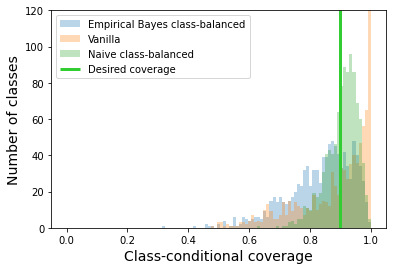

In [203]:
bins = np.linspace(0,1,100)
plt.hist(class_specific_cov, bins=bins, label="Empirical Bayes class-balanced", alpha=.3)
plt.hist(vanilla_class_specific_cov, bins=bins, label="Vanilla", alpha=.3)
plt.hist(naivecb_class_specific_cov, bins=bins, label="Naive class-balanced", alpha=.3)

plt.vlines(1-alpha, 0, 120, label='Desired coverage', color='limegreen', linewidth=3)
plt.ylim(0,120)

plt.ylabel('Number of classes', fontsize=14)
plt.xlabel('Class-conditional coverage', fontsize=14)
plt.legend()
plt.show()

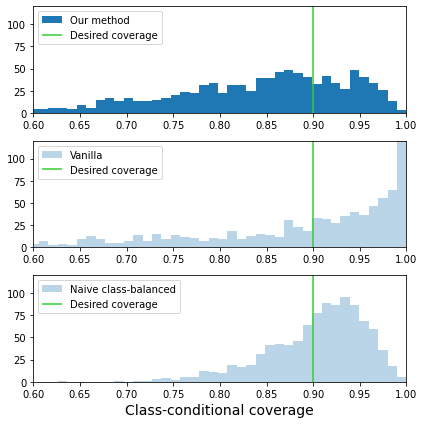

In [204]:
# The same histograms as above, except on separate plots
fig, axs = plt.subplots(3,1, figsize=(6, 6))

bins = np.linspace(0, 1, 100)
axs[0].hist(class_specific_cov, bins=bins, label="Our method")
axs[1].hist(vanilla_class_specific_cov, bins=bins, label="Vanilla", alpha=.3)
axs[2].hist(naivecb_class_specific_cov, bins=bins, label="Naive class-balanced", alpha=.3)

for i in range(3):
    axs[i].vlines(1-alpha, 0, 120, label='Desired coverage', color='limegreen')
    axs[i].set_ylim(0, 120)
    axs[i].set_xlim(0.6, 1)
    axs[i].legend(loc='upper left')

plt.xlabel('Class-conditional coverage', fontsize=14)
plt.tight_layout()